In [1]:
import pandas as PD
import numpy as NP
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, cv, DMatrix

import preprof      #my functions

In [2]:
######## to run with the naive dataset, uncomment the following:

# full=False




######## to fun with the full dataset, uncomment below:

full=True




In [3]:
## initialise dataset

if full:
    csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/ready_processed.csv'
else:
    csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/all.csv'

In [4]:
## convert to relevant or not relevant

preprof.tidy_categories(csv)
preprof.binary_categories(csv)
    
papers=PD.read_csv(csv)

In [5]:
## convert into bow/tfidf

rd_seed = 61097
x = [a.split('!$!') for a in papers.loc[:,'words']]
y = papers.loc[:,'category']

def fake_tokeniser(text):
    return text

bag_of_words = CountVectorizer(analyzer='word',tokenizer=fake_tokeniser,preprocessor=fake_tokeniser,lowercase=False,token_pattern=None)
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=fake_tokeniser,preprocessor=fake_tokeniser,lowercase=False,token_pattern=None)

def wm2df(wm, feat_names):  
    doc_names = [f'Doc{idx}' for idx, _ in enumerate(wm)]
    df = PD.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

bow = bag_of_words.fit_transform(x)
bow_names = bag_of_words.get_feature_names()
bow_matrix = wm2df(bow,bow_names)

tfidf = tf_idf.fit_transform(x)
tfidf_names = tf_idf.get_feature_names()
tfidf_matrix = wm2df(tfidf,tfidf_names)

In [6]:
##split train/test

x_train_b,x_test_b,y_train_b,y_test_b=train_test_split(bow,y,test_size=0.15,random_state=rd_seed,stratify=y)
x_train_t,x_test_t,y_train_t,y_test_t=train_test_split(tfidf,y,test_size=0.15,random_state=rd_seed,stratify=y)

In [7]:
bowmodel=XGBClassifier().fit(x_train_b,y_train_b)
selection = SelectFromModel(bowmodel, threshold=0.006968641, prefit=True)
x_train_b=selection.transform(x_train_b)
x_test_b=selection.transform(x_test_b)

In [8]:
tfidfmodel=XGBClassifier().fit(x_train_t,y_train_t)
selectiont = SelectFromModel(tfidfmodel,threshold=0.0067,prefit=True)
x_train_t=selectiont.transform(x_train_t)
x_test_t=selectiont.transform(x_test_t)

In [9]:
print(x_train_b.shape)

(1599, 36)


In [10]:
print(x_train_t.shape)

(1599, 50)


<br><br><br><br><br><br><br><br>

# hyperparameter tuning: xgboost BoW

In [11]:
original=XGBClassifier().fit(x_train_b,y_train_b)
y_proriginal=original.predict(x_test_b)
original_acc=accuracy_score(y_test_b,y_proriginal)
original_f1=f1_score(y_test_b,y_proriginal,pos_label='Relevant')

print('Before hyperparameter tuning...')
print(f'Accuracy={original_acc}     f1={original_f1}')

Before hyperparameter tuning...
Accuracy=0.901060070671378     f1=0.8627450980392157


### optimisation of n_estimators

In [12]:
xgb_b=XGBClassifier(n_estimators=200,seed=61097)

In [13]:
xgb_b.fit(x_train_b,y_train_b,eval_set=[(x_train_b,y_train_b),
                                         (x_test_b,y_test_b)],
           eval_metric='error',verbose=False)

xgb_b_eval=xgb_b.evals_result()
n_estimators=range(len(xgb_b_eval['validation_0']['error']))

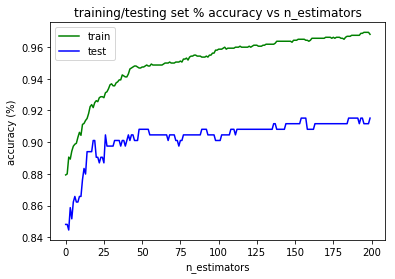

In [14]:
plt.plot(n_estimators,[1-n for n in xgb_b_eval['validation_0']['error']],color='g',label='train')
plt.plot(n_estimators,[1-n for n in xgb_b_eval['validation_1']['error']],color='b',label='test')
plt.legend()
plt.title('training/testing set % accuracy vs n_estimators')
plt.ylabel('accuracy (%)')
plt.xlabel('n_estimators')
plt.show()

The test set accuracy stops improving at around n_estimators=25. Above this, there is overfitting of the training set.<br>
So when doing GridSearch cross-validation, it's not necessary to go as high as 200.

### learning rate

In [15]:
## iterating through various learning rates to find the best one!

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
f1_scores_xgb={}
acc_scores_xgb={}

for lr in learning_rate:
    model = XGBClassifier(n_estimators=25,seed=61097,learning_rate=lr)
    model.fit(x_train_b,y_train_b)
    y_test_pred=model.predict(x_test_b)
    f1=f1_score(y_test_b,y_test_pred,pos_label='Relevant')
    f1_scores_xgb[str(lr)]=f1
    acc=accuracy_score(y_test_b,y_test_pred)
    acc_scores_xgb[str(lr)]=acc
    print('.',end='')

..........

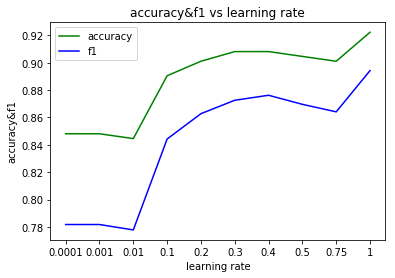

In [16]:
plt.plot(acc_scores_xgb.keys(),acc_scores_xgb.values(),color='g',label='accuracy')
plt.plot(f1_scores_xgb.keys(),f1_scores_xgb.values(),color='b',label='f1')
plt.legend()
plt.title('accuracy&f1 vs learning rate')
plt.ylabel('accuracy&f1')
plt.xlabel('learning rate')
plt.show()

In [17]:
## testing parameter values around the optimal point

learning_rate = [round(x,2) for x in NP.linspace(0.75,1,13)]
f1_scores_xgb={}
acc_scores_xgb={}

for lr in learning_rate:
    model = XGBClassifier(n_estimators=25,seed=61097,learning_rate=lr)
    model.fit(x_train_b,y_train_b)
    y_test_pred=model.predict(x_test_b)
    f1=f1_score(y_test_b,y_test_pred,pos_label='Relevant')
    f1_scores_xgb[str(lr)]=f1
    acc=accuracy_score(y_test_b,y_test_pred)
    acc_scores_xgb[str(lr)]=acc
    print('.',end='')

.............

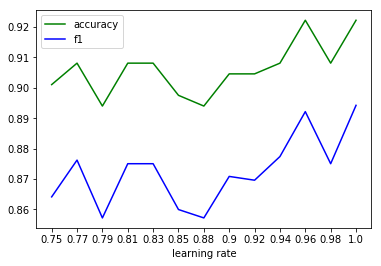

In [18]:
plt.plot(acc_scores_xgb.keys(),acc_scores_xgb.values(),color='g',label='accuracy')
plt.plot(f1_scores_xgb.keys(),f1_scores_xgb.values(),color='b',label='f1')
plt.legend()
plt.xlabel('learning rate')
plt.show()

From the graph, optimal learning rate = 1

### max depth

In [19]:
## iterating through various max_depth values to find the best

depth = list(range(2,11))
f1_xgb_depth={}
acc_xgb_depth={}


for d in depth:
    model = XGBClassifier(n_estimators=25,seed=61097,learning_rate=1,max_depth=d)
    model.fit(x_train_b,y_train_b)
    y_test_pred=model.predict(x_test_b)
    f1=f1_score(y_test_b,y_test_pred,pos_label='Relevant')
    f1_xgb_depth[d]=f1
    acc=accuracy_score(y_test_b,y_test_pred)
    acc_xgb_depth[d]=acc
    print('.',end='')

.........

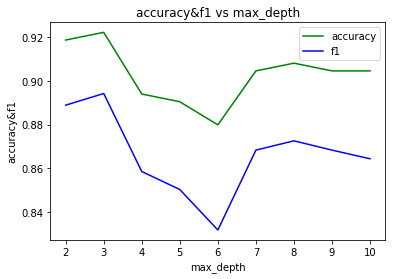

In [20]:
plt.plot(acc_xgb_depth.keys(),acc_xgb_depth.values(),color='g',label='accuracy')
plt.plot(f1_xgb_depth.keys(),f1_xgb_depth.values(),color='b',label='f1')
plt.legend()
plt.title('accuracy&f1 vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('accuracy&f1')
plt.show()

optimal max_depth is 3

### GridSearchCV for gamma, colsamples_bytree & regularisation (alpha & lambda)

In [21]:
## current optimal classifier

xgb_b = XGBClassifier(n_estimators=25,seed=61097,learning_rate=1,max_depth=3)
xgb_b.fit(x_train_b,y_train_b)
y_pred_=xgb_b.predict(x_test_b)

print(accuracy_score(y_test_b,y_pred_))
print(f1_score(y_test_b,y_pred_,pos_label='Relevant'))

0.9222614840989399
0.8942307692307693


In [22]:
## gamma optimisation

param_grid={'gamma':[x/10 for x in range(10)]}

grid = GridSearchCV(estimator=xgb_b,
                param_grid=param_grid,
                verbose=1,
                cv=5)
grid_result = grid.fit(x_train_b,y_train_b)

print('Best Score:', round(grid_result.best_score_*100,2))
print('Best Params:', grid_result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 91.12
Best Params: {'gamma': 0.2}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.5s finished


In [23]:
xgb_gam=XGBClassifier(max_depth=3,learning_rate=1,
                      n_estimators=25,random_state=61097
                      ,gamma=0.2)
xgb_gam.fit(x_train_b,y_train_b)

y_pred_gam=xgb_gam.predict(x_test_b)
print(accuracy_score(y_test_b,y_pred_gam))
print(f1_score(y_test_b,y_pred_gam,pos_label='Relevant'))

0.911660777385159
0.8792270531400966


Tuned gamma worsens model so stick w default values<br><br><br><br><br>

In [24]:
## subsample & colsample_bytree optimisation

param_grid = {'subsample':[x/10 for x in range(6,10)],
              'colsample_bytree':[x/10.0 for x in range(6,10)]}

grid = GridSearchCV(estimator=xgb_b,
                param_grid=param_grid,
                verbose=1,
                cv=5)
grid_result = grid.fit(x_train_b,y_train_b)

print('Best Score:', round(grid_result.best_score_*100,2))
print('Best Params:', grid_result.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 90.87
Best Params: {'colsample_bytree': 0.7, 'subsample': 0.7}


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.7s finished


In [25]:
## f1 score for optimised colsample_bytree and subsample

xgb_csbt_ss=XGBClassifier(n_estimators=25, seed=61097, max_depth=3,
                          learning_rate=1, colsample_bytree=0.7,
                          subsample=0.7)
xgb_csbt_ss.fit(x_train_b,y_train_b)
y_pred_cs = xgb_csbt_ss.predict(x_test_b)


print(accuracy_score(y_test_b,y_pred_cs))
print(f1_score(y_test_b,y_pred_cs,pos_label='Relevant'))

0.8939929328621908
0.8514851485148516


Tuning these hyperparameters makes the model worse!<br><br><br><br>

In [26]:
## regularisation term (alpha&lambda) tuning

alphas = [10**x for x in range(-2,3)]
lambdas = [10**x for x in range(-2,3)]
param_grid_al={'reg_alpha':alphas,'reg_lambda':lambdas}

grid = GridSearchCV(estimator=xgb_b,
                param_grid=param_grid_al,
                verbose=1,
                cv=5)
grid_result = grid.fit(x_train_b,y_train_b)

print('Best Score:', round(grid_result.best_score_*100,2))
print('Best Params:', grid_result.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Score: 91.87
Best Params: {'reg_alpha': 0.1, 'reg_lambda': 10}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    8.6s finished


In [27]:
## add optimal alpha and lambda values to the model

xgb_b_al=XGBClassifier(n_estimators=25,seed=61097,max_depth=3,learning_rate=1,
                       reg_alpha=0.01,reg_lambda=10)
xgb_b_al.fit(x_train_b,y_train_b)
y_pred_b_al=xgb_b_al.predict(x_test_b)


print(accuracy_score(y_test_b,y_pred_b_al))
print(f1_score(y_test_b,y_pred_b_al,pos_label='Relevant'))

0.911660777385159
0.8780487804878048


Tuning of alpha and lambda actually makes the model worse so let's stick with the default values.

### xgb_b tuning conclusion

In [28]:
print('Before hyperparameter tuning...')
print(f'Accuracy={original_acc}     f1={original_f1}')

Before hyperparameter tuning...
Accuracy=0.901060070671378     f1=0.8627450980392157


In [29]:
optimal_xgb_b=XGBClassifier(n_estimators=25,seed=61097,
                            max_depth=3,learning_rate=1).fit(x_train_b,y_train_b)
y_proptimal=optimal_xgb_b.predict(x_test_b)
optimal_acc=accuracy_score(y_test_b,y_proptimal)
optimal_f1=f1_score(y_test_b,y_proptimal,pos_label='Relevant')

print('After hyperparameter tuning...')
print(f'Accuracy={optimal_acc}     f1={optimal_f1}')

After hyperparameter tuning...
Accuracy=0.9222614840989399     f1=0.8942307692307693


In [30]:
print(classification_report(y_test_b,y_proptimal))

              precision    recall  f1-score   support

Not relevant       0.94      0.93      0.94       180
    Relevant       0.89      0.90      0.89       103

   micro avg       0.92      0.92      0.92       283
   macro avg       0.91      0.92      0.92       283
weighted avg       0.92      0.92      0.92       283



So hyperparameter tuning has improved the model's accuracy by around 2 percentage points and its f1 score by 3 points.

In [31]:
## save optimal classifier

for x,y in optimal_xgb_b.get_xgb_params().items():
    print(f'{x} = {y}')

top_3={}
top_3['XGB_b']=(optimal_acc,optimal_f1)

base_score = 0.5
booster = gbtree
colsample_bylevel = 1
colsample_bytree = 1
gamma = 0
learning_rate = 1
max_delta_step = 0
max_depth = 3
min_child_weight = 1
missing = None
n_estimators = 25
nthread = 1
objective = binary:logistic
reg_alpha = 0
reg_lambda = 1
scale_pos_weight = 1
seed = 61097
silent = 1
subsample = 1


<br><br><br><br><br><br><br><br><br><br>

# hyperparameter tuning: xgboost tfidf

In [32]:
original_xgbt=XGBClassifier().fit(x_train_t,y_train_t)
y_original_p=original_xgbt.predict(x_test_t)
xgbt_org_acc=accuracy_score(y_test_t,y_original_p)
xgbt_org_f1=f1_score(y_test_t,y_original_p,pos_label='Relevant')

print('Before hyperparameter tuning...')
print('accuracy={}      f1={}'.format(round(xgbt_org_acc,5),round(xgbt_org_f1,5)))

Before hyperparameter tuning...
accuracy=0.9258      f1=0.89756


### n_estimators optimisation

In [33]:
xgb_t=XGBClassifier(seed=61097,n_estimators=200)

In [34]:
xgb_t.fit(x_train_t,y_train_t,eval_set=[(x_train_t,y_train_t),(x_test_t,y_test_t)],
           eval_metric='error',verbose=False)

xgb_t_eval=xgb_t.evals_result()
n_estimators=range(len(xgb_t_eval['validation_0']['error']))

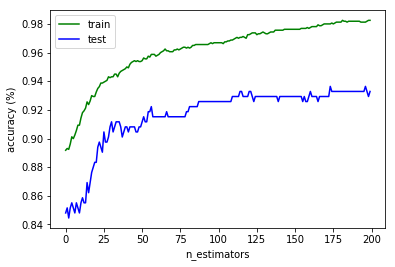

In [35]:
plt.plot(n_estimators,[1-n for n in xgb_t_eval['validation_0']['error']],color='g',label='train')
plt.plot(n_estimators,[1-n for n in xgb_t_eval['validation_1']['error']],color='b',label='test')
plt.legend()
plt.ylabel('accuracy (%)')
plt.xlabel('n_estimators')
plt.show()

The test set accuracy stops increasing at n_estimators=80. From then on there is overfitting to the training set.

### learning_rate

In [36]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
f1_lr_t={}
acc_lr_t={}

for lr in learning_rate:
    model = XGBClassifier(n_estimators=80,seed=61097,learning_rate=lr)
    model.fit(x_train_t,y_train_t)
    y_test_pred=model.predict(x_test_t)
    f1=f1_score(y_test_t,y_test_pred,pos_label='Relevant')
    f1_lr_t[str(lr)]=f1
    acc=accuracy_score(y_test_t,y_test_pred)
    acc_lr_t[str(lr)]=acc
    print('.',end='')

..........

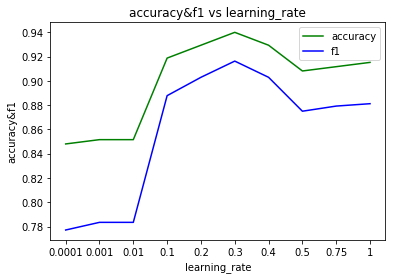

In [37]:
plt.plot(acc_lr_t.keys(),acc_lr_t.values(),color='g',label='accuracy')
plt.plot(f1_lr_t.keys(),f1_lr_t.values(),color='b',label='f1')
plt.legend()
plt.title('accuracy&f1 vs learning_rate')
plt.ylabel('accuracy&f1')
plt.xlabel('learning_rate')
plt.show()

In [38]:
## now we test parameter values around the point learning_rate=0.3

learning_rate = [round(x,2) for x in NP.linspace(0.24,0.34,21)]

f1_lr_t={}
acc_lr_t={}

for lr in learning_rate:
    model = XGBClassifier(n_estimators=80,seed=61097,learning_rate=lr)
    model.fit(x_train_t,y_train_t)
    y_test_pred=model.predict(x_test_t)
    f1=f1_score(y_test_t,y_test_pred,pos_label='Relevant')
    f1_lr_t[str(lr)]=f1
    acc=accuracy_score(y_test_t,y_test_pred)
    acc_lr_t[str(lr)]=acc
    print('.',end='')

.....................

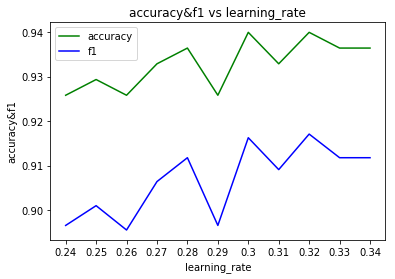

In [39]:
plt.plot(acc_lr_t.keys(),acc_lr_t.values(),color='g',label='accuracy')
plt.plot(f1_lr_t.keys(),f1_lr_t.values(),color='b',label='f1')
plt.legend()
plt.title('accuracy&f1 vs learning_rate')
plt.ylabel('accuracy&f1')
plt.xlabel('learning_rate')
plt.show()

So our learning_rate value will be <b>0.32</b>

In [40]:
learn={'learning_rate':0.32,'n_estimators':80}
xgb_t.set_params(**learn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.32, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=61097,
       silent=True, subsample=1)

### max_depth optimisation

In [41]:
depth = list(range(2,11))
f1_depth_t={}
acc_depth_t={}

for d in depth:
    model = XGBClassifier(n_estimators=80,seed=61097,learning_rate=0.32,max_depth=d)
    model.fit(x_train_t,y_train_t)
    y_test_pred=model.predict(x_test_t)
    f1=f1_score(y_test_t,y_test_pred,pos_label='Relevant')
    f1_depth_t[d]=f1
    acc=accuracy_score(y_test_t,y_test_pred)
    acc_depth_t[d]=acc
    print('{} '.format(d),end='')

2 3 4 5 6 7 8 9 10 

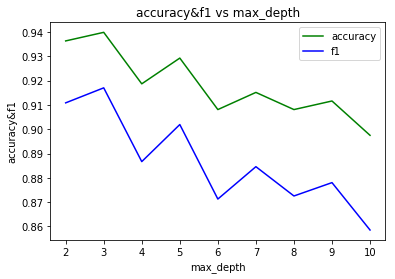

In [42]:
plt.plot(acc_depth_t.keys(),acc_depth_t.values(),color='g',label='accuracy')
plt.plot(f1_depth_t.keys(),f1_depth_t.values(),color='b',label='f1')
plt.legend()
plt.title('accuracy&f1 vs max_depth')
plt.ylabel('accuracy&f1')
plt.xlabel('max_depth')
plt.show()

From the graph, optimal max_depth = 3

### gamma

In [43]:
## current optimal classifier

xgb_t = XGBClassifier(n_estimators=80,seed=61097,
                      learning_rate=0.32,
                      max_depth=3)
xgb_t.fit(x_train_t,y_train_t)
y_t2_pred=xgb_t.predict(x_test_t)

In [44]:
print(accuracy_score(y_test_t,y_t2_pred))
print(f1_score(y_test_t,y_t2_pred,pos_label='Relevant'))

0.9399293286219081
0.9170731707317074


In [45]:
param_grid={'gamma':[x/10 for x in range(5)]}

grid = GridSearchCV(estimator=xgb_t,
                param_grid=param_grid,
                verbose=1,
                cv=5)
grid_result = grid.fit(x_train_t,y_train_t)

print('Best Score:', round(grid_result.best_score_*100,2))
print('Best Params:', grid_result.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.1s finished


Best Score: 92.12
Best Params: {'gamma': 0.1}


In [46]:
xgb_gam = XGBClassifier(n_estimators=80,seed=61097,
                       learning_rate=0.32,
                       max_depth=3,
                       gamma=0.1).fit(x_train_t,y_train_t)
y_gampred=xgb_gam.predict(x_test_t)

print('acc')
print(accuracy_score(y_test_t,y_gampred))
print('\nf1')
print(f1_score(y_test_t,y_gampred,pos_label='Relevant'))

acc
0.9469964664310954

f1
0.9268292682926829


This gamma value improves our acc and f1!! so we keep it

In [47]:
xgb_t.set_params(**{'gamma':0.1})

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.32, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=80,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=61097,
       silent=True, subsample=1)

<br><br><br><br>

### subsample & colsample_bytree

In [48]:
## subsample & colsample_bytree optimisation

param_grid = {'subsample':[x/10 for x in range(6,10)],
              'colsample_bytree':[x/10.0 for x in range(6,10)]}

grid = GridSearchCV(estimator=xgb_t,
                param_grid=param_grid,
                verbose=1,
                cv=5)
grid_result = grid.fit(x_train_t,y_train_t)

print('Best Score:', round(grid_result.best_score_*100,2))
print('Best Params:', grid_result.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   32.7s finished


Best Score: 92.06
Best Params: {'colsample_bytree': 0.6, 'subsample': 0.9}


In [49]:
xgb_ss = XGBClassifier(n_estimators=80,seed=61097,
                       learning_rate=0.32,max_depth=3,
                       gamma=0.1,
                       colsample_bytree=0.6,
                       subsample=0.9)
xgb_ss.fit(x_train_t,y_train_t)
y_ss_pred=xgb_ss.predict(x_test_t)

print(accuracy_score(y_test_t,y_ss_pred))
print(f1_score(y_test_t,y_ss_pred,pos_label='Relevant'))

0.9328621908127208
0.9073170731707318


The f1 scores for the optimised colsample_bytree and subsample parameters is lower than the f1 score when these parameters have their default value...<br>
This is also the case when using just one of these parameters and not the other.<br>
Thus they do not require tuning!<br><br><br><br>

In [50]:
## optimising regularisation hyperparameters: alpha & lambda

alphas = [10**x for x in range(-2,3)]
lambdas = [10**x for x in range(-2,3)]
param_grid_alph={'reg_alpha':alphas,'reg_lambda':lambdas}

grid = GridSearchCV(estimator=xgb_t,
                param_grid=param_grid_alph,
                verbose=1,
                cv=5)
grid_result = grid.fit(x_train_t,y_train_t)

print('Best Score:', round(grid_result.best_score_*100,2))
print('Best Params:', grid_result.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   42.1s finished


Best Score: 92.06
Best Params: {'reg_alpha': 1, 'reg_lambda': 10}


In [51]:
##add optimal alpha and lambda values to the model

xgb_al2=XGBClassifier(n_estimators=80, seed=61097,
                     max_depth=3, learning_rate=0.32,
                     gamma=0.1).set_params(**grid_result.best_params_)
xgb_al2.fit(x_train_t,y_train_t)
y_pred_al2=xgb_al2.predict(x_test_t)


print(accuracy_score(y_test_t,y_pred_al2))
print(f1_score(y_test_t,y_pred_al2,pos_label='Relevant'))

0.9257950530035336
0.8975609756097561


Tuning these parameters makes the model worse so leave at default values<br><br><br><br>

### xgb_t conclusion

In [52]:
print('Before hyperparameter tuning...')
print('accuracy={}      f1={}'.format(round(xgbt_org_acc,5),round(xgbt_org_f1,5)))

Before hyperparameter tuning...
accuracy=0.9258      f1=0.89756


In [53]:
optimal_xgbt=XGBClassifier(n_estimators=80,max_depth=3,
                           seed=61097,learning_rate=0.32,
                           gamma=0.1)
optimal_xgbt.fit(x_train_t,y_train_t)
y_optimal_p=optimal_xgbt.predict(x_test_t)
xgbt_opt_acc=accuracy_score(y_test_t,y_optimal_p)
xgbt_opt_f1=f1_score(y_test_t,y_optimal_p,pos_label='Relevant')

print('After hyperparameter tuning...')
print('accuracy={}      f1={}'.format(round(xgbt_opt_acc,5),round(xgbt_opt_f1,5)))

After hyperparameter tuning...
accuracy=0.947      f1=0.92683


In [54]:
print(classification_report(y_test_t,y_optimal_p))

              precision    recall  f1-score   support

Not relevant       0.96      0.96      0.96       180
    Relevant       0.93      0.92      0.93       103

   micro avg       0.95      0.95      0.95       283
   macro avg       0.94      0.94      0.94       283
weighted avg       0.95      0.95      0.95       283



So hyperparameter tuning has improved the model's accuracy by 1.4 percentage points and f1 by 2 points

In [55]:
top_3['XGB_t']=(xgbt_opt_acc,xgbt_opt_f1)

# evaluation of tuned classifiers

In [56]:
for x,y in top_3.items():
    print(x)
    print(y)
    print()

XGB_b
(0.9222614840989399, 0.8942307692307693)

XGB_t
(0.9469964664310954, 0.9268292682926829)



The best classifier according to accuracy and f1 metrics is <b>XGBOOST TFIDF</b>

In [57]:
pickle.dump(optimal_xgb_b,open('optimal_xgb_bow','wb'))

In [58]:
pickle.dump(optimal_xgbt,open('optimal_xgb_tfidf','wb'))